In [1]:
import os
import urllib.request

#create a folder for the dataset
os.makedirs('./data', exist_ok = True)

# load dataset to the directory--as you can see, you must load train sets and test sets separately
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

('./data/test-labels.gz', <http.client.HTTPMessage at 0x7f4c6bea7c18>)

In [2]:
import gzip
import numpy as np
import struct

# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

print('Functions defined')

Functions defined


In [3]:
# To help the model converge faster, shrink the intensity values (X) from 0-255 to 0-1

X_train = load_data('./data/train-images.gz', False) / 255.0
y_train = load_data('./data/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)

print('Data loaded')

Data loaded


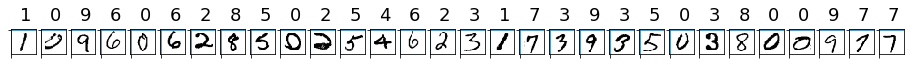

Done


In [4]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np


count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
    
plt.show()

print('Done')

In [5]:
from sklearn.linear_model import LogisticRegression

#load the model
clf = LogisticRegression()
#fit the model
clf.fit(X_train, y_train)

#evaluate the model by using a test set
y_hat = clf.predict(X_test)
#print the accuracy
print(np.average(y_hat == y_test))

print('Done')

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9201
Done


In [6]:
from azureml.core import Workspace,Experiment,Run

ws = Workspace.create(
            name='AMLSWorkspace',
            subscription_id='PROVIDE YOUR SUBSCRIPTION ID HERE', 
            resource_group='rgAMLSLearnworkspace',
            create_resource_group=True,
            location='southeastasia'
)

Deploying AppInsights with name amlsworkinsightsbae7424c.
Deployed AppInsights with name amlsworkinsightsbae7424c. Took 10.69 seconds.
Deploying KeyVault with name amlsworkkeyvaultf03e1981.
Deploying StorageAccount with name amlsworkstoragece9429027.
Deployed KeyVault with name amlsworkkeyvaultf03e1981. Took 25.87 seconds.
Deployed StorageAccount with name amlsworkstoragece9429027. Took 51.42 seconds.
Deploying Workspace with name AMLSWorkspace.
Deployed Workspace with name AMLSWorkspace. Took 35.1 seconds.


In [7]:
from azureml.core import Experiment
#Create an experiment
experiment = Experiment(workspace = ws, name = "my-first-experiment")

#Create a run
run = experiment.start_logging()
run.log("trial",1)
run.complete()

In [8]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [9]:
print(run.get_portal_url())

https://ml.azure.com/experiments/my-first-experiment/runs/403c6e45-9aeb-40d4-9060-730ebfe16fb3?wsid=/subscriptions/f6b4e95b-44f4-4587-865a-97ade75f98f6/resourcegroups/rgAMLSLearnworkspace/workspaces/AMLSWorkspace


In [10]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# Step 1: name the cluster and set the minimal and maximal number of nodes 
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 3)

# Step 2: choose environment variables 
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")

provisioning_config = AmlCompute.provisioning_configuration(
    vm_size = vm_size, min_nodes = min_nodes, max_nodes = max_nodes)

# create the cluster
compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

print('Compute target created')

Compute target created


In [11]:
#upload data by using get_default_datastore()
ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='mnist', overwrite=True, show_progress=True)

print('Done')

Uploading an estimated of 4 files
Uploading ./data/test-images.gz
Uploading ./data/test-labels.gz
Uploading ./data/train-images.gz
Uploading ./data/train-labels.gz
Uploaded ./data/test-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/train-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/train-images.gz, 4 files out of an estimated total of 4
Uploaded 4 files
Done


In [12]:
import os

# create the folder
folder_training_script = './trial_model_mnist'
os.makedirs(folder_training_script, exist_ok=True)

print('Done')

Done


In [13]:
%%writefile $folder_training_script/train.py

import argparse
import os
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from azureml.core import Run
# from utils import load_data

import gzip
import struct

# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

###
data_folder = os.path.join(args.data_folder, 'mnist')
print('Data folder:', data_folder)

# load the train and test set into numpy arrays
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0

#print variable set dimension
print(X_train.shape, X_test.shape, sep = '\n')

y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

#print the response variable dimension
print( y_train.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Writing ./trial_model_mnist/train.py


In [14]:
from azureml.train.sklearn import SKLearn

script_params = {
    '--data-folder': ds.as_mount(),
    '--regularization': 0.5
}

#import the Scikit-learn package 
est = SKLearn(source_directory=folder_training_script,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn'])

WARNING - You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['scikit-learn']. We cannot guarantee image build will succeed.


In [15]:
from azureml.core import Experiment

#Create an experiment
experiment = Experiment(workspace = ws, name = "amls-learn-experimentnew5")

print('Experiment created')

Experiment created


In [16]:
run = experiment.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
amls-learn-experimentnew5,amls-learn-experimentnew5_1576577639_df74e818,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [17]:
# monitor the run
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [18]:
#get the result
print(run.get_metrics())

{}


In [19]:
model = run.register_model(model_name='sklearn_mnist_model.pkl',
                           model_path='outputs/sklearn_mnist_model.pkl',
                           tags = {'area': "MNIST", 'type': "sklearn"},
                           description = "identify numbers")

print(model.name, model.id, model.version, sep='\t')

sklearn_mnist_model.pkl	sklearn_mnist_model.pkl:1	1


In [20]:
%%writefile score.py
from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from azureml.core.model import Model
import numpy
import json

def init():
    global model
    model_path = Model.get_model_path('sklearn_mnist_model.pkl')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

# note you can pass in multiple rows for scoring
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = numpy.array(data)
        result = model.predict(data)
        # you can return any datatype if it is JSON-serializable
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

Writing score.py


In [21]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

print('Done')

Done


In [22]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script="score.py",
                                 conda_file="myenv.yml",
                                 tags = {'data': "MNIST", 'type': "sklearn"},
                                 description = "Image for sklearn model")

image = Image.create(name = "myimage1",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

print('Done')

Creating image
Running...................................
Succeeded
Image creation operation finished for image myimage1:1, operation "Succeeded"
Done


In [23]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                          memory_gb = 1, 
                                          tags = {"data": "mnist", "type": "sklearn"}, 
                                          description = 'Handwriting recognition')

print('Done')

Done


In [24]:
from azureml.core.webservice import Webservice

service_name = 'aci-mnist-1'

service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                            image = image,
                                            name = service_name,
                                            workspace = ws)

service.wait_for_deployment(show_output = True)

print('Done')

Running............
Succeeded
ACI service creation operation finished, operation "Succeeded"
Done


In [25]:
import os 

import gzip
import struct
import numpy as np


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

data_folder = os.path.join(os.getcwd(), 'data')

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_test = load_data(os.path.join(
    data_folder, 'test-labels.gz'), True).reshape(-1)

print('Done')

Done


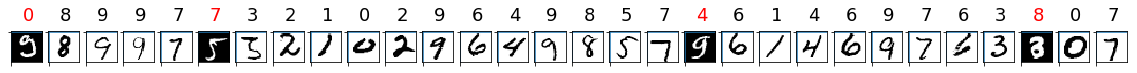

In [26]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize=(20, 1))
#plt.figure(figsize=(9, 3))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)

    i = i + 1

plt.show()

In [27]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type': 'application/json'}

# for AKS deployment you'd need to include the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://5fd75fd2-9c60-4411-b8a5-03e15248fd49.southeastasia.azurecontainer.io/score
label: 0
prediction: [0]


In [28]:
# Load the diabetes dataset, a well-known built-in small dataset that comes with scikit-learn.
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print('Done')

Done


In [29]:
from azureml.core.experiment import Experiment

experiment = Experiment(workspace = ws, name = "my-third-experiment")

print('Done')

Done


In [30]:
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
import logging

automl_config = AutoMLConfig(task = 'regression',
                  iteration_timeout_minutes = 10,
                  iterations = 3,
                  primary_metric = 'spearman_correlation',
                  n_cross_validations = 5,
                  debug_log = 'automl.log',
                  verbosity = logging.INFO,
                  X = X_train, 
                  y = y_train)

print('Done')

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


Done


In [31]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_60b4f5bb-e17a-4a75-b33e-13eac4b2d1eb
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper RandomForest             0:01:08       0.7005    0.7005
         1   MinMaxScaler RandomForest                      0:01:07       0.6732    0.7005
         2   StandardScalerWrapper ExtremeRandomTrees   

In [32]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [33]:
best_run, fitted_model = local_run.get_output()

In [34]:
y_pred_train = fitted_model.predict(X_train)
y_residual_train = y_train - y_pred_train
y_pred_test = fitted_model.predict(X_test)
y_residual_test = y_test - y_pred_test

In [ ]:
ws.delete(delete_dependent_resources=True)